In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

build_df = pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv")
sample = pd.read_csv("../input/ashrae-energy-prediction/sample_submission.csv")
test_df = pd.read_csv("../input/ashrae-energy-prediction/test.csv")
#train_df = pd.read_csv("../input/ashrae-energy-prediction/train.csv")
#weather_test_df = pd.read_csv("../input/ashrae-energy-prediction/weather_test.csv")
#weather_train_df = pd.read_csv("../input/ashrae-energy-prediction/weather_train.csv")

In [2]:
np.set_printoptions(suppress=True)
pd.set_option('precision', 5) #设置精度
pd.set_option('display.float_format', lambda x: '%.5f' % x)
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)

In [3]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
#train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
#weather_train_df = reduce_mem_usage(weather_train_df)
#weather_test_df = reduce_mem_usage(weather_test_df)
build_df = reduce_mem_usage(build_df)

Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [5]:
leak_df = pd.read_feather('../input/ashrae-leak-data-station/leak.feather')
leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]

In [6]:
! ls ../input

another-1-08-lb-no-leak			   ashrae-leak-data-station
ashrae-energy-prediction		   kernel6ff2111519
ashrae-kfold-lightgbm-without-building-id  lightgbm114


In [7]:
sample_submission1 = pd.read_csv('../input/ashrae-kfold-lightgbm-without-building-id/submission.csv', index_col=0)
sample_submission2 = pd.read_csv('../input/another-1-08-lb-no-leak/fe2_lgbm.csv', index_col=0)
sample_submission3 = pd.read_csv('../input/kernel6ff2111519/lgb-window2.csv', index_col=0)

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
test_df['pred1'] = sample_submission1.meter_reading
test_df['pred2'] = sample_submission2.meter_reading
test_df['pred3'] = sample_submission3.meter_reading
print('5')
del  sample_submission1,  sample_submission2,  sample_submission3
gc.collect()

test_df = reduce_mem_usage(test_df)
leak_df = reduce_mem_usage(leak_df)

5
Mem. usage decreased to 1073.68 Mb (30.8% reduction)
Mem. usage decreased to 276.03 Mb (40.0% reduction)


In [9]:
leak_df['meter']=leak_df['meter'].apply('int8')
test_df['timestamp']=pd.to_datetime(test_df['timestamp'])

In [10]:
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'pred1', 'pred2', 'pred3', 'row_id']], left_on = ['building_id', 'meter', 'timestamp'], right_on = ['building_id', 'meter', 'timestamp'], how = "left")
leak_df = leak_df.merge(build_df[['building_id', 'site_id']], on='building_id', how='left')

In [11]:
leak_df['pred1_l1p'] = np.log1p(leak_df.pred1)
leak_df['pred2_l1p'] = np.log1p(leak_df.pred2)
leak_df['pred3_l1p'] = np.log1p(leak_df.pred3)
leak_df['meter_reading_l1p'] = np.log1p(leak_df.meter_reading)

In [12]:
leak_df.head()

,building_id,meter,meter_reading,timestamp,pred1,pred2,pred3,row_id,site_id,pred1_l1p,pred2_l1p,pred3_l1p,meter_reading_l1p
0,0,0,173.37030,2017-01-01,159.97556,146.52629,115.65690,0,0,5.08125,4.99401,4.75924,5.16118
1,1,0,53.51272,2017-01-01,72.20270,82.68028,68.73670,1,0,4.29323,4.42700,4.24473,3.99843
2,2,0,6.14304,2017-01-01,12.16220,9.96421,12.67350,2,0,2.57735,2.39464,2.61546,1.96614
3,3,0,101.70147,2017-01-01,215.52441,247.37108,255.97020,3,0,5.37770,5.51492,5.54896,4.63183
4,4,0,1141.24072,2017-01-01,976.01031,1131.21143,857.26392,4,0,6.88450,7.03193,6.75491,7.04075


In [13]:
N = 10
scores = np.zeros(N,)
for i in range(N):
    p = i * 1./N
    v = p * leak_df['pred1'].values + (1.-p) * leak_df ['pred3'].values
    vl1p = np.log1p(v)
    scores[i] = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))

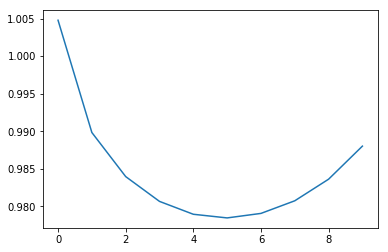

In [14]:
plt.plot(scores)

In [15]:
best_weight = np.argmin(scores) *  1./N
print (scores.min(), best_weight)

0.9784585237503052 0.5


In [16]:
scores = np.zeros(N,)
for i in range(N):
    p = i * 1./N
    v =  p * (best_weight * leak_df['pred1'].values + (1.-best_weight) * leak_df ['pred3'].values) + (1.-p) * leak_df ['pred2'].values
    vl1p = np.log1p(v)
    scores[i] = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))

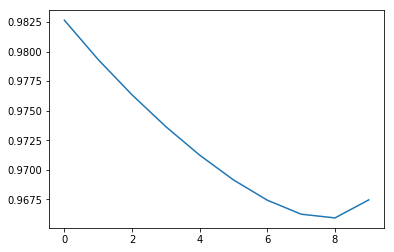

In [17]:
plt.plot(scores)

In [18]:
best_weight2 = np.argmin(scores) *  1./N
print (scores.min(), best_weight2)

0.9659334421157837 0.8


In [19]:
all_combinations = list(np.linspace(0.2,0.5,31))
all_combinations

[0.2,
 0.21000000000000002,
 0.22,
 0.23,
 0.24000000000000002,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29000000000000004,
 0.30000000000000004,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41000000000000003,
 0.42000000000000004,
 0.43000000000000005,
 0.44,
 0.45,
 0.46,
 0.47000000000000003,
 0.48000000000000004,
 0.49,
 0.5]

In [20]:
import itertools
l = [all_combinations, all_combinations, all_combinations]
# remember to do the reverse!
all_l = list(itertools.product(*l)) + list(itertools.product(*reversed(l)))

In [21]:
filtered_combis = [l for l in all_l if l[0] + l[1] + l[2] > 0.93 and l[0] + l[1] + l[2] < 1.03]


In [22]:
print(len(filtered_combis))


12142


In [23]:
best_combi = [] # of the form (i, score)
for i, combi in enumerate(filtered_combis):
    #print("Now at: " + str(i) + " out of " + str(len(filtered_combis))) # uncomment to view iterations
    score1 = combi[0]
    score2 = combi[1]
    score3 = combi[2]
    v = score1 * leak_df['pred1'].values + score2 * leak_df['pred3'].values + score3 * leak_df['pred2'].values
    vl1p = np.log1p(v)
    curr_score = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))
    
    if best_combi:
        prev_score = best_combi[0][1]
        if curr_score < prev_score:
            best_combi[:] = []
            best_combi += [(i, curr_score)]
    else:
        best_combi += [(i, curr_score)]
            
score = best_combi[0][1]
print(score)

0.9608066


In [24]:

# extract best combination
final_combi = filtered_combis[best_combi[0][0]]
w1 = final_combi[0]
w2 = final_combi[1]
w3 = final_combi[2]
print("The weights are: w1=" + str(w1) + ", w2=" + str(w2) + ", w3=" + str(w3))

sample['meter_reading'] = w1 * test_df.pred1 +  w2 * test_df.pred3  + w3 * test_df.pred2
sample.loc[sample.meter_reading < 0, 'meter_reading'] = 0

The weights are: w1=0.30000000000000004, w2=0.42000000000000004, w3=0.21000000000000002


In [25]:
leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
sample.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']

In [26]:
sample.to_csv('blend1.csv', index=False, float_format='%.4f')
